#### 1. 使用豆瓣电影评论数据完成文本分类处理：文本预处理，加载、构建词典。（评论得分1～2 表示positive取值：1，评论得分4～5代表negative取值：0）
#### 2. 加载处理后文本构建词典、定义模型、训练、评估、测试。
#### 3. 尝试不同分词工具进行文本分词，观察模型训练结果。



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("utmhikari/doubanmovieshortcomments")

print("Path to dataset files:", path)

100%|██████████| 144M/144M [03:16<00:00, 765kB/s]  

Extracting files...


Path to dataset files: /Users/peiqi/.cache/kagglehub/datasets/utmhikari/doubanmovieshortcomments/versions/7


In [4]:
#文本预处理
import csv
import jieba

ds_comments = []

with open('/Users/peiqi/code/AiPremiumClass/李思佳/week07/DMSC.csv', 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        vote = int(row['Star'])
        if vote in [1,2,4,5]:
            words = jieba.lcut(row['Comment'])
            if vote in [1, 2]:
                ds_comments.append((words, 0))
            elif vote in [4, 5]:
                ds_comments.append((words, 1)) #1好评 0差评

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/tl/s657k2kn70zdpt9vn9hq4cpm0000gq/T/jieba.cache
Loading model cost 0.412 seconds.
Prefix dict has been built successfully.


<function matplotlib.pyplot.show(close=None, block=None)>

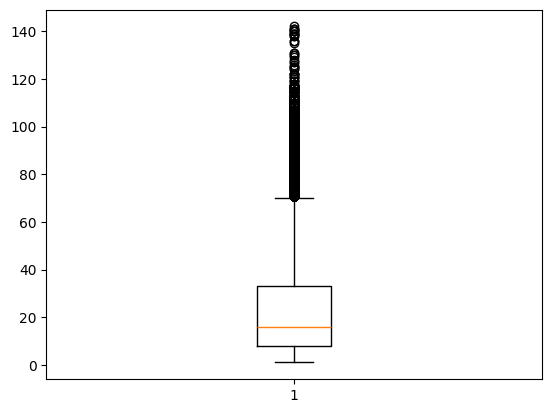

In [5]:
#### 分析评论长度，考虑截取过长、过短评论
import matplotlib.pyplot as plt

comments_len = [len(c) for c, v in ds_comments]
# plt.hist(comments_len, bins=100)
# plt.show
plt.boxplot(comments_len)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

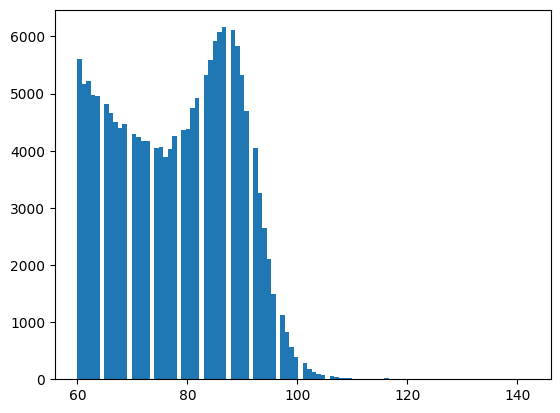

In [25]:
#评论词汇长度在10-150之前

ds_comments = [c for c in ds_comments if len(c[0]) in range(60, 150)]

comments_len = [len(c) for c, v in ds_comments]
plt.hist(comments_len, bins=100)
plt.show

In [26]:
import pickle

with open('/Users/peiqi/code/AiPremiumClass/李思佳/week07/dbpl.pkl','wb') as f:
    pickle.dump(ds_comments, f)

In [27]:
#加载训练语料
with open('/Users/peiqi/code/AiPremiumClass/李思佳/week07/dbpl.pkl', 'rb') as f:
    comments_data = pickle.load(f)

#构建词典
def build_from_doc(doc):
    vocab = set()
    for line in doc:
        if line[0] is not None:
            vocab.update(line[0])
    # 移除可能存在的 None
    vocab.discard(None)
    vocab = ['PAD','UNK'] + list(vocab) #pad :padding, unk: unknown
    w2idx = {word:idx for idx, word in enumerate(vocab)}
    print(w2idx)
    return w2idx

vocab = build_from_doc(comments_data)

{'PAD': 0, 'UNK': 1, '单开': 2, '有抖': 3, '今年过年': 4, '发心': 5, '打火': 6, '展会': 7, '救护车': 8, '昭然若揭': 9, '生理': 10, '猛然间': 11, '幸于': 12, '斩除': 13, '🐙': 14, '兩大聯合': 15, '快逃': 16, '歐美國家算': 17, '郝建': 18, '哈根达斯': 19, '萌坏': 20, '玩太過': 21, '基地': 22, '有云': 23, 'time': 24, '高燃': 25, '教从': 26, '肥鱼': 27, '🙁': 28, '過多': 29, '修房子': 30, '商厦': 31, '水乳交融': 32, 'TST': 33, '有主有': 34, '迷弟': 35, '17.28': 36, '一无': 37, '結尾略顯': 38, '拉钱': 39, '野战军': 40, '無法': 41, '博山': 42, '党点': 43, '小姨': 44, '你霞姐': 45, '毒到': 46, '提心': 47, '最正': 48, '验赞': 49, '但梦前': 50, '单剧': 51, '阿皇': 52, '激賞': 53, '女兵': 54, '死不休': 55, '逆來': 56, '连导': 57, 'highness': 58, '昨夜': 59, '前头': 60, '笑酸': 61, '只会用': 62, '米外': 63, '固定化': 64, 'ǔ': 65, '付钱': 66, '粉拍': 67, '一衝動給': 68, '辛辣': 69, 'Jimmy': 70, '白展': 71, 'States': 72, '比梦': 73, '凡出': 74, '媲烂': 75, '一抬眸': 76, '截肢': 77, '惨叫': 78, '不會花': 79, '隱喻諷': 80, '吴莫愁': 81, '调且': 82, '卡死': 83, '贩烟': 84, '一瞧': 85, '流川枫': 86, '黑人': 87, '兔粑': 88, '漂': 89, '铁汉': 90, '提早': 91, '相拟': 92, '深知': 93, '但现': 94, '北滨': 95,

In [28]:
len(vocab)

173339

In [29]:
# 通过dataset构建DataLoader
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence #长度不同的张量填充为相同长度
import torch

#自定义回调函数
#自定义数据转换方法（callback function 回调函数）
def convert_data(batch_data):
    comments, votes = [], []
    # 分别提取评论和标签
    for comment, vote in batch_data:
        comments.append(torch.tensor([vocab.get(word, vocab['UNK']) for word in comment]))
        votes.append(vote)
    # 将评论和标签统一转换为张量
    commt =  pad_sequence(comments, batch_first=True, padding_value=vocab['PAD']) #填充为相同长度，batch_first批次在第0个位置，
    labels = torch.tensor(votes)
    return commt, labels

dataloader = DataLoader(comments_data, batch_size=128, shuffle=True,collate_fn=convert_data)  #collate_fn：回调,惰性方法



In [30]:
#构建模型
import torch.nn as nn
class Comments_Classifier(nn.Module):
    def __init__(self, vocal_size, embedding_dim, hidden_size, num_classes):
        super().__init__()
        self.embedding =nn.Embedding(vocal_size, embedding_dim, padding_idx=0)
        self.rnn = nn.LSTM(embedding_dim, hidden_size,batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, input_ids):
        #input_ids:{batch_size, seq_len}
        #embedded:{batch_size, seq_len, embeding_dim} seq_len:训练长度
        embedded = self.embedding(input_ids)    
        # output:(batch_size, seq_len, hidden_size)
        output, (hidden, _) = self.rnn(embedded)
        output = self.fc(output[:,-1,:]) #取最后一个时间步的输出
        return output
    
    
embedding_dim = 200
hidden_size = 10
num_classes = 2
vocab_size = len(vocab)

emb = nn.Embedding(len(vocab), embedding_dim) #词汇表大小len(vocab)，向量维度100

model = Comments_Classifier(len(vocab),embedding_dim,hidden_size, num_classes )
print(model)

#定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#训练模型
num_epoch = 3
for epochs in range(num_epoch):
    for i, (cmt, lbl) in enumerate(dataloader):
        #前向传播
        outputs = model(cmt)
        loss = criterion(outputs, lbl)
        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 10 == 0:
            print(f'Epoch [{epochs+1}/{num_epoch}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')


Comments_Classifier(
  (embedding): Embedding(173339, 200, padding_idx=0)
  (rnn): LSTM(200, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=2, bias=True)
)
Epoch [1/3], Step [10/1351], Loss: 0.5970
Epoch [1/3], Step [20/1351], Loss: 0.5589
Epoch [1/3], Step [30/1351], Loss: 0.5518
Epoch [1/3], Step [40/1351], Loss: 0.5585
Epoch [1/3], Step [50/1351], Loss: 0.5510
Epoch [1/3], Step [60/1351], Loss: 0.5258
Epoch [1/3], Step [70/1351], Loss: 0.5145
Epoch [1/3], Step [80/1351], Loss: 0.5293
Epoch [1/3], Step [90/1351], Loss: 0.4511
Epoch [1/3], Step [100/1351], Loss: 0.5212
Epoch [1/3], Step [110/1351], Loss: 0.5427
Epoch [1/3], Step [120/1351], Loss: 0.5608
Epoch [1/3], Step [130/1351], Loss: 0.4634
Epoch [1/3], Step [140/1351], Loss: 0.5216
Epoch [1/3], Step [150/1351], Loss: 0.5499
Epoch [1/3], Step [160/1351], Loss: 0.5046
Epoch [1/3], Step [170/1351], Loss: 0.5218
Epoch [1/3], Step [180/1351], Loss: 0.4757
Epoch [1/3], Step [190/1351], Loss: 0.5455
Epoch [1/3], Step

In [31]:
# 保存模型
torch.save(model.state_dict(), '/Users/peiqi/code/AiPremiumClass/李思佳/week07/comments_classifier.pth')
#保存词典
torch.save(vocab, '/Users/peiqi/code/AiPremiumClass/李思佳/week07/comments_vocab.path')

In [ ]:
# 测试模型
commet1 = "这电影真好看，全程无尿点"
commet2 = "看一半就不想看了，真无聊"

vocab = torch.load('/Users/peiqi/code/AiPremiumClass/李思佳/week07/comments_vocab.path', weights_only=False)
# vocab = list(vocab)
# 将评论转化为索引

commet1_idx = torch.tensor([vocab.get(word, vocab['UNK']) for word in jieba.lcut(commet1)])
commet2_idx = torch.tensor([vocab.get(word, vocab['UNK']) for word in jieba.lcut(commet2)])
# #将评论转化为tensor
commet1_idx = commet1_idx.unsqueeze(0) #添加batch维度
commet2_idx = commet2_idx.unsqueeze(0) #添加batch维度

# 加载模型
model = Comments_Classifier(len(vocab),100,128,2)
model.load_state_dict(torch.load('/Users/peiqi/code/AiPremiumClass/李思佳/week07/comments_classifier.pth', weights_only=False))

#模型推理
pred1 = model(commet1_idx)
pred2= model(commet2_idx)

#取最大值的索引作为预测结果
pred1 = torch.argmax(pred1, dim=1).item()
pred2 = torch.argmax(pred2, dim=1).item()